In [1]:
!pip install datasets sentencepiece multipledispatch

In [2]:
import os
import torch
from torch import nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import numpy as np
import sentencepiece as spm
import random
from torch.utils.data import Dataset
import datasets
from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
from multipledispatch import dispatch
from torchtext.data.metrics import bleu_score
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
random_seed = 39
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.manual_seed(random_seed)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
all_data = datasets.load_dataset(
    'cointegrated/ru-paraphrase-NMT-Leipzig', 
    data_files={"train": "train.csv","val": "val.csv","test": "test.csv"},
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/cointegrated--ru-paraphrase-NMT-Leipzig-f187aea54ca79219/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)
/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ru_list = []
en_list = []
def write2file(data):
    for i in "original", "en":
        for j in data[i]:
            if j is None:
                continue
            a = del_punkt.tokenize(j.lower())
            a = ' '.join(a)
            if i == "original":
                ru_list.append(a)
            else:
                en_list.append(a)

del_punkt = RegexpTokenizer(r'\w+')
for i in "train", "val", "test":
    write2file(all_data[i])
!touch ru.txt en.txt

with open(r'/content/ru.txt', 'w') as fp:
    fp.write('\n'.join(ru_list))

with open(r'/content/en.txt', 'w') as fp:
    fp.write('\n'.join(en_list))

In [ ]:
ru_vocab_size = 5000
spm.SentencePieceTrainer.train(f'--input=/content/ru.txt --pad_id=3 --model_prefix=ru_un --vocab_size={ru_vocab_size}')
ru_tokenizer = spm.SentencePieceProcessor(model_file='/content/ru_un.model')

In [ ]:
en_vocab_size = 5000
spm.SentencePieceTrainer.train(f'--input=/content/en.txt --pad_id=3 --model_prefix=en_un --vocab_size={en_vocab_size}')
eu_tokenizer = spm.SentencePieceProcessor(model_file='/content/en_un.model')

In [36]:
print(f'bos= eu - {eu_tokenizer.bos_id()}, ru - {ru_tokenizer.bos_id()}', )
print(f'eos= eu - {eu_tokenizer.eos_id()}, ru - {eu_tokenizer.eos_id()}', )
print(f'unk= eu - {eu_tokenizer.unk_id()}, ru - {eu_tokenizer.unk_id()}', )
print(f'pad= eu - {eu_tokenizer.pad_id()}, ru - {eu_tokenizer.pad_id()}' )

bos= eu - 1, ru - 1
eos= eu - 2, ru - 2
unk= eu - 0, ru - 0
pad= eu - 3, ru - 3


In [10]:
ru_tokenizer.encode("мама готовит ужин каждый день"), eu_tokenizer.encode("mum cooks dinner every day")

([3114, 626, 102, 1098, 185, 583, 357], [3316, 1750, 5, 3556, 300, 162])

In [11]:
class Data(Dataset):#transform
    def __init__(self, all_data, start = 0, ru_tokenizer = ru_tokenizer, eu_tokenizer = eu_tokenizer):
        end = min(start + len(all_data), start + int(1e5))
        if len(all_data['original']) > 1e5:
            self.original = all_data['original'][start : end]
            self.translation = all_data['en'][start : end]
        else:
            self.original = all_data['original']
            self.translation = all_data['en']
        self.ru_tokenizer = ru_tokenizer
        self.eu_tokenizer = eu_tokenizer
        self.del_punkt = tokenizer = RegexpTokenizer(r'\w+')
      
    def __len__(self):
        return len(self.translation)
  
    def __getitem__(self, idx):
        try:
            a = self.del_punkt.tokenize(self.original[idx].lower()) # without bos and eos
            b = self.del_punkt.tokenize(self.translation[idx].lower()) # without bos and eos
            a = ' '.join(a)
            b = ' '.join(b)
            return self.ru_tokenizer.encode(a), self.eu_tokenizer.encode(b), self.original[idx], self.translation[idx]
        except:
            return self.__getitem__(0)



val_dataset = Data(all_data['val'])
test_dataset = Data(all_data['test'])

In [12]:
def data_processing(data):
    ru_f = []
    eu_f = []
    ru_text = []
    eu_text = []
    for ru_enc, eu_enc, org_ru, org_eu in data:
        ru_enc = torch.Tensor(ru_enc).to(torch.long)
        eu_enc = torch.Tensor(eu_enc + [eu_tokenizer.eos_id()]).to(torch.long)

        ru_f.append(ru_enc)
        eu_f.append(eu_enc)
        ru_text.append(org_ru)
        eu_text.append(org_eu)
        
    ru_f = torch.nn.utils.rnn.pad_sequence(ru_f, batch_first=True, padding_value = ru_tokenizer.pad_id())
    eu_f = torch.nn.utils.rnn.pad_sequence(eu_f, batch_first=True, padding_value = eu_tokenizer.pad_id())
    return ru_f, eu_f, ru_text, eu_text

In [13]:
batch_size = 32

val_loader = data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x),
                                )
test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x),
                                )

In [14]:
def get_num_params(model):
    res = 0
    for i in model.parameters():
        k = 1
        for j in range(len(i.shape)):
            k *= i.shape[j]
        res += k
    print("Number of parameters:", res)

def get_bleu(pred, tr):
    a = [eu_tokenizer.decode(i).split() for i in pred]
    b = [[eu_tokenizer.decode(i).split()] for i in tr]
    return bleu_score(a, b)

In [15]:
def train_chunk(model, optimizer, loader, max_epochs = 50, tf = True,
                cross_loss = nn.CrossEntropyLoss(ignore_index=eu_tokenizer.pad_id()).to(device)):

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15, gamma=0.1)
    best_b = 0
    list_bleu = []
    list_loss = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loader.items():
            y_tr = []
            y_pr = []
            sum_loss = 0
            for x_batch, y_batch,  ru_text, eu_text in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch, y_batch) if tf else model(x_batch, y = y_batch, p = 1)
                    loss = cross_loss(outp.transpose(2, 1), y_batch)
                    loss.backward()
                    optimizer.step()  
                else:
                    model.eval() 
                    with torch.inference_mode():
                        outp = model(x_batch, y_batch) if tf else model(x_batch, y = y_batch, p = 1)
                        loss = cross_loss(outp.transpose(2, 1), y_batch)
                        y_pr.extend(torch.max(outp, -1)[1].to('cpu').tolist())  
                    y_tr.extend(y_batch.to('cpu').tolist())
                sum_loss += loss.item()
            normilaze = len(loader['train']) if k == "train" else len(loader['valid'])
            if k == "train":
                print(f"Epoch: {epoch+1}")
                scheduler.step()
            print(f"Loader: {k}. Cross entropy: {sum_loss / normilaze}")
            list_loss[k].append(sum_loss / normilaze)
            if k=="valid":
                w = get_bleu(y_pr, y_tr)
                print(f'\t\tBLEU: {w}')
                list_bleu.append(w)
                if best_b < w:
                    torch.save(model.state_dict(), "./model.pth")
                    best_b = w
    return list_loss, list_bleu

def train(model, optimizer, num_chunks = 1, max_epochs = 10, tf = True):
    cross, bleu = [], []
    start = 0
    loader = {'train' : None, 'valid' : val_loader}
    for i in range(num_chunks):
        train_dataset = Data(all_data['train'], start = start)
        train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x),
                                )
        loader['train'] = train_loader
        list_loss, list_bleu = train_chunk(model, optimizer, loader, max_epochs, tf)
        cross.append(list_loss)
        bleu.append(list_bleu)
    return cross, bleu

In [16]:
@torch.inference_mode()
def test_model(model, print_best = 5, print_worst = 5, tf = True):
    model.eval()
    y_tr = []
    y_pr = []
    obj = []
    for x_batch, y_batch,  ru_text, eu_text in tqdm(test_loader, leave=False, desc=f"test iter:"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outp = model(x_batch)[0] if tf else model(x_batch, p = 0)
        pr = torch.max(outp, -1)[1].to('cpu').tolist()
        y_pr.extend(pr)
        tr = y_batch.to('cpu').tolist()
        y_tr.extend(tr)
        for i, j, k in zip(pr, tr, x_batch):
            obj.append((get_bleu([i], [j]), eu_tokenizer.decode(i), eu_tokenizer.decode(j),
                        ru_tokenizer.decode(k.tolist())))
    w = get_bleu(y_pr, y_tr)
    print(f'BLEU: {w}')
    print("Worst translations:")
    obj.sort(key = lambda x: x[0])
    for s, (i, j, k, l) in enumerate(obj[ : print_worst]):
        print(f"bleu = {i}\nRussian text: {l}\nMy_translation: {j}\nData_translation: {k}\n")
    print("Best translations:")
    for s, (i, j, k, l) in enumerate(obj[:-print_best - 1:-1]):
        print(f"bleu = {i}\nRussian text: {l}\nMy_translation: {j}\nData_translation: {k}\n")
    return w, obj

# Model 1 - Recurent with attention

Данную модель я учил в сумме часа 24, переходя с кагла на колаб и т.д. Поэтому результаты последовательного прогресса при обучения не сохранились, но при переходе я сохранял веса, поэтому некоторые из них доступны.

In [17]:
def get_mask(x):
    res = torch.ones_like(x)
    res[x == ru_tokenizer.pad_id()] = 0
    return res

class Recurent(nn.Module):
    def __init__(
        self,
        vocab_size_ru = len(ru_tokenizer),
        vocab_size_eu = len(eu_tokenizer),
        hidden_size=100,
        bidirectional=True,
        num_layers_enc=1,
        num_layers_dec=1,
        dropout=0.0,
        embedding_dim=100
    ):
        super(Recurent, self).__init__()
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.ru_embed = nn.Embedding(vocab_size_ru, embedding_dim, padding_idx = ru_tokenizer.pad_id())

        self.eu_embed = nn.Embedding(vocab_size_eu, embedding_dim, padding_idx = eu_tokenizer.pad_id())

        self.encoder = nn.LSTM(embedding_dim, hidden_size,
                               num_layers_enc, bidirectional=bidirectional, dropout = dropout,
                               batch_first = True)
        
        self.sz = (self.bidirectional + 1) * self.num_layers_enc

        self.decoder = nn.LSTM(embedding_dim, (self.bidirectional + 1) * self.hidden_size,
                               num_layers_dec, batch_first = True)
        
        self.fc = nn.Linear((self.bidirectional + 1) * self.hidden_size * 2, vocab_size_eu)

    def forward(self, inpt, max_count = 100, y = None, p = 1., t = 0., need_idx = False):
        x = self.ru_embed(inpt) # b t f
        idx_all = []
        h0 = torch.zeros(self.sz, len(x), self.hidden_size).to(device)
        c0 = torch.zeros(self.sz, len(x), self.hidden_size).to(device)
        at_vec, (h, c) = self.encoder(x, (h0, c0))
        h = h[-1 - self.bidirectional :].view(len(x), self.hidden_size *
                        (self.bidirectional + 1)).unsqueeze(0).repeat(self.num_layers_dec, 1, 1)
        c = c[-1 - self.bidirectional :].view(len(x), self.hidden_size * 
                        (self.bidirectional + 1)).unsqueeze(0).repeat(self.num_layers_dec, 1, 1)
        res = []
        idx = torch.LongTensor([[eu_tokenizer.bos_id()] * len(x)]).to(device)
        sh_y = max_count if y is None else y.shape[1]
        mask = get_mask(inpt)
        eos_fl = torch.zeros(len(x)).to(device)
        for i in range(sh_y):
            a = self.eu_embed(idx)[0].unsqueeze(1)
            out, (h, c) = self.decoder(a, (h, c))
            attention = F.softmax(torch.einsum('bij,bkj->bik', at_vec, out).squeeze(2) * mask / np.sqrt(at_vec.shape[2]), -1)
            attention_res = torch.einsum('bij,bi->bj', at_vec, attention)
            out = self.fc(torch.cat((out.squeeze(1),attention_res), 1))
            res.append(out)
            if y is not None and torch.rand(1).item() < p:
                idx = y[:, i]
            else:
                with torch.no_grad():
                    if t == 0:
                        idx = torch.max(out.detach(), -1)[1]
                    else:
                        idx = torch.tensor([torch.multinomial(i, 1) for i in F.softmax(out / t, -1)]).to(device)
                if y is None:
                    eos_fl[idx == eu_tokenizer.eos_id()] = 1
                    if torch.sum(eos_fl).item() == len(x):
                        idx_all.append(idx)
                        break
            idx_all.append(idx)
            idx = idx.unsqueeze(0)
        if not need_idx:
            return torch.stack(res).transpose(0, 1)
        return torch.stack(res).transpose(0, 1), torch.stack(idx_all).transpose(0, 1)
model_rec = Recurent(hidden_size=200, embedding_dim=200, num_layers_enc = 2,
            num_layers_dec=1, dropout=0.0, bidirectional=True).to(device)
get_num_params(model_rec)

Number of parameters: 8574600


In [ ]:
optimizer_rec = optim.AdamW(model_rec.parameters(), lr=5e-4)
cross_rec, bleu_rec = train(model_rec, optimizer_rec, num_chunks = 10, max_epochs = 10, tf = False)

In [27]:
model_rec.load_state_dict(torch.load('/kaggle/input/last-weights/model(11).pth'))

<All keys matched successfully>

In [28]:
%%time
model_rec(next(iter(val_loader))[0].to(device), y = next(iter(val_loader))[1].to(device))
print("Train:")

Train:
CPU times: user 56 ms, sys: 972 µs, total: 56.9 ms
Wall time: 56.9 ms


In [29]:
%%time
model_rec(next(iter(val_loader))[0].to(device))
print("Test:")

Test:
CPU times: user 59.8 ms, sys: 813 µs, total: 60.6 ms
Wall time: 60.1 ms


In [17]:
test_model(model_rec, tf = False)
print()

test iter::   0%|          | 0/313 [00:00<?, ?it/s]

BLEU: 0.23122741281986237
Worst translations:
bleu = 0.0
Russian text: некоммерческое партнерство глобальная энергия объявляет о старте очередного международного медийного конкурса энергия пера
My_translation: the non profit partnership global energy announces the start of another regular media competition per perimeter
Data_translation: global energy a non profit partnership announces the launch of another international media contest pen energy

bleu = 0.0
Russian text: это рефлекс в тени
My_translation: it is a reflection in the shade
Data_translation: it s a reflex in the shadows

bleu = 0.0
Russian text: он не вернётся
My_translation: he won t come back
Data_translation: will he not return

bleu = 0.0
Russian text: сказали что прям в них и можно выпекать
My_translation: they said that they could be baked in them and can be baked
Data_translation: they said it s straight into them and you can bake

bleu = 0.0
Russian text: едва сигранд отделился от остальных чтобы пойди проверить ка

Получились достаточно неплохие результаты, но очень долго длиться обучение. Если взять больше параметров, то можно достичь и существенно лучших результатов, но на колабе этого уже не проверить адекватно.

# Model 2 - Transformer

Обучение в разы быстрее, лучше результаты, в общем в целом модель намного лучше. Но на инференсе скорость работы просаживается.

In [30]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x.transpose(1, 0)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x).transpose(1, 0)


def transformer_mask(x, pad_id):
    return (x == pad_id).to(device)
    
class Transformer_model(nn.Module):
    def __init__(
        self,
        vocab_size_ru = len(ru_tokenizer),
        vocab_size_eu = len(eu_tokenizer),
        d_model = 512,
        nhead = 8,
        num_encoder_layers = 6,
        num_decoder_layers = 6,
        dim_feedforward = 2048,
        dropout = 0.1
    ):
        super(Transformer_model, self).__init__()
        self.ru_embed = nn.Embedding(vocab_size_ru, d_model, padding_idx = ru_tokenizer.pad_id())
        self.eu_embed = nn.Embedding(vocab_size_eu, d_model, padding_idx = eu_tokenizer.pad_id())

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.pos = PositionalEncoding(d_model, max_len = 1000)
        self.fc = nn.Linear(d_model, vocab_size_eu)

    @dispatch(object, object)
    def forward(self, src, tgt):
        src_key_padding_mask = transformer_mask(src, ru_tokenizer.pad_id())
        tgt_key_padding_mask = transformer_mask(tgt, eu_tokenizer.pad_id())
        memory_key_padding_mask = src_key_padding_mask
        tgt_mask = torch.triu(torch.full((tgt.shape[1], tgt.shape[1]), True, device=device), diagonal=1)
        bos_ten = torch.Tensor([eu_tokenizer.bos_id()] * len(tgt))[:, None].to(device)
        tgt = bos_ten if tgt is None else torch.cat((bos_ten, tgt[:, : -1]), -1).to(torch.long)
        src = self.pos(self.ru_embed(src)) # b t f
        tgt = self.pos(self.eu_embed(tgt)) # b t f 
        encoder_outp = self.encoder(src, src_key_padding_mask=src_key_padding_mask)

        res = self.decoder(tgt=tgt, memory = encoder_outp, tgt_key_padding_mask = tgt_key_padding_mask, 
                                     tgt_mask=tgt_mask, memory_key_padding_mask = memory_key_padding_mask)
        res = self.fc(res)
        return res

    @dispatch(object)
    def forward(self, src, max_count = 80, t = 0):
        src_key_padding_mask = transformer_mask(src, ru_tokenizer.pad_id())
        memory_key_padding_mask = src_key_padding_mask
        src = self.pos(self.ru_embed(src))
        encoder_outp = self.encoder(src, src_key_padding_mask=src_key_padding_mask)

        tgt = torch.Tensor([eu_tokenizer.bos_id()] * len(src))[:, None].to(device).to(torch.long)
        eos_fl = torch.zeros(len(src)).to(device)
        res, idx_all = [], []
        flag_end = False
        i = 0
        while i < max_count or not flag_end:
            i += 1
            if i > 80:
                break
            vec_tgt = self.pos(self.eu_embed(tgt))
            tgt_key_padding_mask = transformer_mask(tgt, eu_tokenizer.pad_id())
            tgt_key_padding_mask = transformer_mask(tgt, eu_tokenizer.pad_id())
            if t == 0:
                self.eval()
                with torch.inference_mode():
                    out = self.decoder(tgt=vec_tgt, memory = encoder_outp, tgt_key_padding_mask = tgt_key_padding_mask,
                                       memory_key_padding_mask = memory_key_padding_mask)[:, -1, :]
                    out = self.fc(out)
                idx = torch.max(out, -1)[1]
            else:
                self.train()
                out = self.decoder(tgt=vec_tgt, memory = encoder_outp, tgt_key_padding_mask = tgt_key_padding_mask, 
                                      memory_key_padding_mask = memory_key_padding_mask)[:, -1, :]
                out = self.fc(out)
                idx = torch.tensor([torch.multinomial(i, 1) for i in F.softmax(out / t, -1)]).to(device)
            res.append(out)
            if not flag_end:
                idx_all.append(idx)
            eos_fl[idx == eu_tokenizer.eos_id()] = 1
            if torch.sum(eos_fl).item() == len(src):
                flag_end = True
            if  flag_end and t == 0:
                break
            tgt = torch.cat((tgt, idx[ : , None]), axis = 1).to(torch.long)
        return torch.stack(res).transpose(0, 1), torch.stack(idx_all).transpose(0, 1)

model = Transformer_model(d_model = 200, nhead = 4,
        num_encoder_layers = 3,
        num_decoder_layers = 3,dim_feedforward = 1000).to(device)
model.ru_embed = model_rec.ru_embed
model.eu_embed = model_rec.eu_embed
# del model_rec
get_num_params(model)

Number of parameters: 6865400


In [27]:
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
cross_tf, bleu_tf = train(model, optimizer, num_chunks = 1, max_epochs = 25)

Epoch: 1
Loader: train. Cross entropy: 4.980862467498779
Loader: valid. Cross entropy: 3.8868521013960673
		BLEU: 0.07663336396217346
Epoch: 2
Loader: train. Cross entropy: 3.68241282333374
Loader: valid. Cross entropy: 3.1393039515985848
		BLEU: 0.12388382107019424
Epoch: 3
Loader: train. Cross entropy: 3.185075378036499
Loader: valid. Cross entropy: 2.8427059696124384
		BLEU: 0.15202346444129944
Epoch: 4
Loader: train. Cross entropy: 2.91657557975769
Loader: valid. Cross entropy: 2.684888760502727
		BLEU: 0.15943823754787445
Epoch: 5
Loader: train. Cross entropy: 2.7309890816497804
Loader: valid. Cross entropy: 2.5360872958795713
		BLEU: 0.18841306865215302
Epoch: 6
Loader: train. Cross entropy: 2.591685607147217
Loader: valid. Cross entropy: 2.436945519508264
		BLEU: 0.18248394131660461
Epoch: 7
Loader: train. Cross entropy: 2.4805753675842284
Loader: valid. Cross entropy: 2.349158122135808
		BLEU: 0.2002997249364853
Epoch: 8
Loader: train. Cross entropy: 2.388264556694031
Loader: v

In [32]:
model.load_state_dict(torch.load('/kaggle/working/model.pth'))

<All keys matched successfully>

In [34]:
%%time
model(next(iter(val_loader))[0].to(device), next(iter(val_loader))[1].to(device))
print("Train:")

Train:
CPU times: user 24.5 ms, sys: 2.79 ms, total: 27.3 ms
Wall time: 45.6 ms


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [35]:
%%time
model_rec(next(iter(val_loader))[0].to(device))
print("Test:")

Test:
CPU times: user 61 ms, sys: 2.11 ms, total: 63.1 ms
Wall time: 63.5 ms


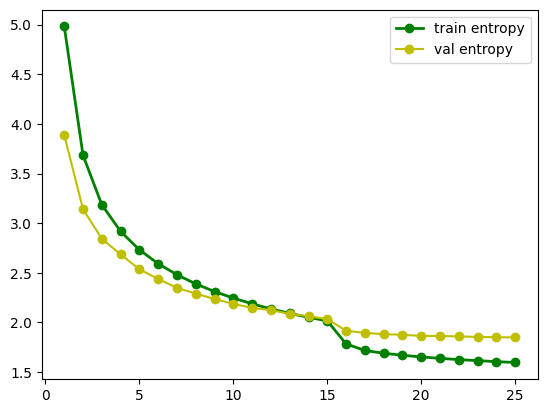

In [70]:
x = list(range(1, len(bleu_tf[0]) + 1))
plt.plot(x, cross_tf[0]['train'], 'go-', label='train entropy', linewidth=2)
plt.plot(x, cross_tf[0]['valid'], 'yo-', label='val entropy')
plt.legend()

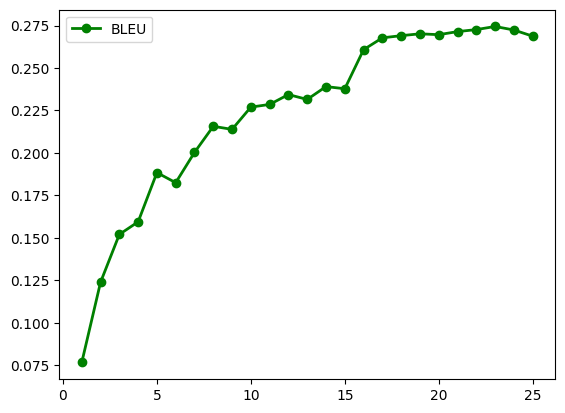

In [71]:
plt.plot(x, bleu_tf[0], 'go-', label='BLEU', linewidth=2)
plt.legend()

In [32]:
test_model(model)
print()

BLEU: 0.25391942416117264
Worst translations:
bleu = 0.0
Russian text: некоммерческое партнерство глобальная энергия объявляет о старте очередного международного медийного конкурса энергия пера
My_translation: the global energy announces the global energy contest
Data_translation: global energy a non profit partnership announces the launch of another international media contest pen energy

bleu = 0.0
Russian text: он не вернётся
My_translation: he won t come back
Data_translation: will he not return

bleu = 0.0
Russian text: едва сигранд отделился от остальных чтобы пойди проверить как идет подготовка к отплытию подошла рилари
My_translation: barely got away from the rest to check how preparations for heating came to the rearrange came from the rest
Data_translation: no sooner had cigrand separated himself from the rest of the group to check on preparations for his departure than rylari approached

bleu = 0.0
Russian text: со временем произошел существенный прогресс в вычислительной те

Трансформер показал себя очень хорошо. Я обучал на одном чанке данных и относительно недолго

# Self-critical Sequence Training

In [32]:
def reward(idx, y):
    res = []
    for i in range(len(idx)):
        a = [eu_tokenizer.decode(idx[i].tolist()).split()]
        b = [eu_tokenizer.decode(y[i].tolist()).split()]
        res.append(bleu_score(a, [b]))
    return torch.Tensor(res).to(device)

def get_loss_sctc(x_batch, idx):
    norm = torch.sum(idx != eu_tokenizer.pad_id(), -1).to(device)
    norm = []
    x = F.log_softmax(x_batch, -1)
    q = torch.zeros_like(x)
    for i in range(len(idx)):
        sz = 0
        for j in range(idx.shape[1]):
            q[i, j, idx[i, j]] = 1.
            sz += 1
            if idx[i, j] == eu_tokenizer.eos_id():
                break
        norm.append(sz)
    return torch.sum(x * q, (2, 1)) / torch.tensor(norm).to(device)

In [67]:
def train_chunk_sctc(model, loader, max_epochs = 15):
    cross_loss = nn.CrossEntropyLoss(ignore_index=eu_tokenizer.pad_id()).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=4e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)
    best_b = 0
    a = 0.5
    list_loss = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loader.items():
            y_tr = []
            y_pr = []
            sum_loss = 0
            for x_batch, y_batch,  ru_text, eu_text in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)[:, : min(y_batch.shape[1], 80)]
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp, idx = model(x_batch, y = y_batch, t = 3, need_idx = True)
                    loss_entr = cross_loss(outp[:, :y_batch.shape[1],:].transpose(2, 1), y_batch)
                
                    loss_sctc = get_loss_sctc(outp, idx)
                    model.eval()
                    
                    with torch.inference_mode():
                        g_outp, g_idx = model(x_batch, y = y_batch, t = 0, need_idx = True)
                    model.train()
                    
                    rew = reward(idx, y_batch)
                    g_rew = reward(g_idx, y_batch)
                    loss_sctc =  - torch.dot(rew - g_rew, loss_sctc) / len(x_batch)
                    
                    loss = a * loss_entr + (1 - a) * loss_sctc
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                else:
                    model.eval() 
                    with torch.inference_mode():
                        outp = model(x_batch, y = y_batch, p = 0)
                        y_pr.extend(torch.max(outp, -1)[1].to('cpu').tolist())  
                    y_tr.extend(y_batch.to('cpu').tolist())
                
            normilaze = len(loader['train']) if k == "train" else len(loader['valid'])
            if k == "train":
                print(f"Epoch: {epoch+1}")
                scheduler.step()
                prt_loss = sum_loss / normilaze
            else:
                w = get_bleu(y_pr, y_tr)
                prt_loss = w
                if best_b < w:
                    torch.save(model.state_dict(), "./model.pth")
                    best_b = w
            print(f"Loader: {k}. Loss: {prt_loss}")
            list_loss[k].append(prt_loss)
    return list_loss

def train_sctc(model, num_chunks = 1, max_epochs = 6, start = int(5e5)):
    loss_all = []
    loader = { 'train' : None, 'valid' : test_loader}
    for i in range(num_chunks):
        train_dataset = Data(all_data['train'], start = start)
        train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x),
                                )
        print(len(train_dataset))
        loader['train'] = train_loader
        list_loss = train_chunk_sctc(model, loader, max_epochs)
        loss_all.append(list_loss)
    return loss_all

In [68]:
loss_sctc = train_sctc(model_rec)

train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Loss: 1.9634402700887321


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.2422766238451004


train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Loss: 1.8839612365149843


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.2518198788166046


train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Loss: 1.81961976339261


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.2592429518699646


train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Loss: 1.7622944253702133


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.2668145000934601


train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Loss: 1.7096488784296444


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.27353984117507935


train iter::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Loss: 1.6570819642977974


valid iter::   0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Loss: 0.2736375331878662


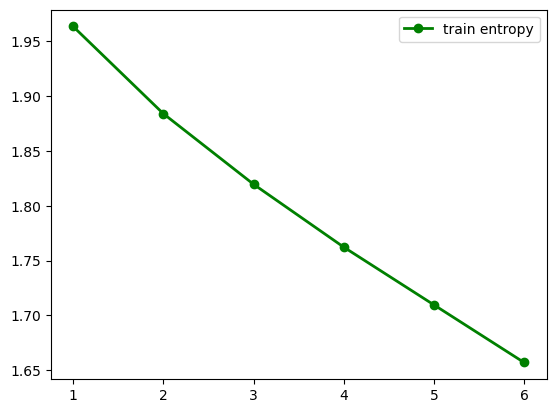

In [71]:
x = list(range(1, len(loss_sctc[0]['train']) + 1))
plt.plot(x, loss_sctc[0]['train'], 'go-', label='train entropy', linewidth=2)
plt.legend()

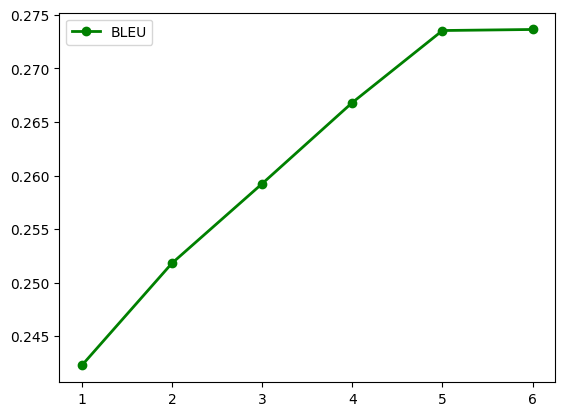

In [72]:
plt.plot(x, loss_sctc[0]['valid'], 'go-', label='BLEU', linewidth=2)
plt.legend()

Пытался использовать данный подход с трансформером, но что-то вообще не получилось, зато с рекурентной моделью получилось отлично! Для валидации в качестве экономии времени сразу использовал test выборку. Получилось улучшить результат. В качестве лоса прибавлял еще и энтропию (a * loss_entr + (1 - a) * loss_sctc). 